In [1]:
import pandas
import numpy as np
import bgshr
import os, pickle
from scipy.stats import gamma
from scipy import interpolate, optimize

In [2]:
import matplotlib, matplotlib.pylab as plt

plt.rcParams["legend.title_fontsize"] = "xx-small"
matplotlib.rc("xtick", labelsize=7)
matplotlib.rc("ytick", labelsize=7)
matplotlib.rc("axes", labelsize=8)
matplotlib.rc("axes", titlesize=8)
matplotlib.rc("legend", fontsize=6)
plt.rcParams['legend.title_fontsize'] = 'xx-small'

Combine lookup tables from moments and classic BGS scenarios.

In [3]:
df_bot = bgshr.Util.load_lookup_table("../lookup_tables/lookup_tbl_2_epochs_bottleneck.csv.gz")
df_exp = bgshr.Util.load_lookup_table("../lookup_tables/lookup_tbl_2_epochs_expansion.csv.gz")

# moderate selection with bottleneck (where CBGS still doesn't work)
df_bot_moderate = bgshr.Util.load_lookup_table("../lookup_tables/lookup_tbl_2_epochs_bottleneck_moderate.csv.gz")
df_bot_moderate = df_bot_moderate[df_bot_moderate["s"] < -0.001]

df_bot = pandas.concat((df_bot_moderate, df_bot), ignore_index=True)

s_exp = -np.logspace(0, -3, 34)[:-1]
s_bot = s_exp[:-8]

rs = np.sort(list(set(df_bot["r"])))
gens = np.sort(list(set(df_bot["Generation"])))

assert(gens.all() == np.sort(list(set(df_exp["Generation"]))).all())
       
df_exp_strong = bgshr.ClassicBGS.build_lookup_table_n_epoch(
    s_exp, rs, [100000, 10000], [0, gens[-1]], 
    generations=gens, 
    uL=1e-8, uR=1e-8)
df_exp = pandas.concat((df_exp_strong, df_exp), ignore_index=True)
df_exp["Ns"] = "100000;10000"

df_bot_strong = bgshr.ClassicBGS.build_lookup_table_n_epoch(
    s_bot, rs, [1000, 10000], [0, gens[-1]], 
    generations=gens, 
    uL=1e-8, uR=1e-8)
df_bot = pandas.concat((df_bot_strong, df_bot), ignore_index=True)

In [4]:
df_exp

,r,s,uL,Order,Generation,Hr,pi0,B,uR,Hl,piN_pi0,piN_piS,Ns,Ts
0,0.000000e+00,-1.0,1.000000e-08,0,0,0.000412,0.000412,1.0,1.000000e-08,NaN,NaN,NaN,100000;10000,0;25000
1,1.000000e-08,-1.0,1.000000e-08,0,0,0.000412,0.000412,1.0,1.000000e-08,NaN,NaN,NaN,100000;10000,0;25000
2,1.258900e-08,-1.0,1.000000e-08,0,0,0.000412,0.000412,1.0,1.000000e-08,NaN,NaN,NaN,100000;10000,0;25000
3,1.584900e-08,-1.0,1.000000e-08,0,0,0.000412,0.000412,1.0,1.000000e-08,NaN,NaN,NaN,100000;10000,0;25000
4,1.995300e-08,-1.0,1.000000e-08,0,0,0.000412,0.000412,1.0,1.000000e-08,NaN,NaN,NaN,100000;10000,0;25000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249691,1.000000e-01,0.0,1.000000e-08,10,2000,0.000396,0.000396,1.0,1.000000e-08,0.000396,1.0,1.0,100000;10000,0;25000
249692,1.000000e-01,0.0,1.000000e-08,10,1500,0.000400,0.000400,1.0,1.000000e-08,0.000400,1.0,1.0,100000;10000,0;25000
249693,1.000000e-01,0.0,1.000000e-08,10,1000,0.000404,0.000404,1.0,1.000000e-08,0.000404,1.0,1.0,100000;10000,0;25000
249694,1.000000e-01,0.0,1.000000e-08,10,500,0.000408,0.000408,1.0,1.000000e-08,0.000408,1.0,1.0,100000;10000,0;25000


In [5]:
_oob_val = 1e20

def obj_func_fixed_mu(params, data=None, verbose=False,
             lower_bound=None, upper_bound=None,
             Bvals_Ne=None, scaling=1):
    if lower_bound is None:
        lower_bound = [0 for _ in params]
    if upper_bound is None:
        upper_bound = [np.inf for _ in params]
    for p, l, u in zip(params, lower_bound, upper_bound):
        if p <= l or p >= u:
            return _oob_val
    assert len(params) == 2
    shape, scale = params
    weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scaling * scale)
    pred = bgshr.Util.integrate_with_weights(Bvals_Ne, weights[:-1], u_fac=scaling)
    ret = np.sum((pred - data) ** 2)
    if verbose:
        print(f"{func_calls}\t{params}\t{ret}")
    return ret

def obj_func_fixed_dfe(params, data=None, verbose=False,
             lower_bound=None, upper_bound=None,
             Bvals_Ne=None, scaling=1,
             shape=None, scale=None):
    if lower_bound is None:
        lower_bound = [0 for _ in params]
    if upper_bound is None:
        upper_bound = [np.inf for _ in params]
    for p, l, u in zip(params, lower_bound, upper_bound):
        if p <= l or p >= u:
            return _oob_val
    assert len(params) == 1
    u_fac = params[0]
    weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scaling * scale)
    pred = bgshr.Util.integrate_with_weights(Bvals_Ne, weights[:-1], u_fac=scaling * u_fac)
    ret = np.sum((pred - data) ** 2)
    if verbose:
        print(f"{func_calls}\t{params}\t{ret}")
    return ret

In [6]:
r = 1e-8
L = 10_000_000

def draw_elements(width=1000, n_elements=20):
    elements = []
    for _ in range(n_elements):
        center = width / 2 + np.random.rand() * (L - width)
        element = [np.max([0, int(center - width / 2)]), np.min([L, int(center + width / 2)])]
        elements.append(element)
    elements = bgshr.Util.break_up_elements(elements)
    return elements

rmap = bgshr.Util.build_uniform_rmap(r, L)

In [7]:
shape = 0.2
scales = [0.005, 0.05, 0.5]
xs = np.linspace(0, L, L // 5000 + 1)

for scale in scales:
    print("mean, variance:", shape * scale, shape * scale ** 2)
    print("ss:", [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1])
    print("cdf:", gamma.cdf([0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], shape, scale=scale))
    print()

mean, variance: 0.001 5e-06
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.31415125 0.49641091 0.7644346  0.98701341 1.
 1.        ]

mean, variance: 0.010000000000000002 0.0005000000000000001
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.19827548 0.31415125 0.49641091 0.7644346  0.98701341
 1.        ]

mean, variance: 0.1 0.05
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.12510713 0.19827548 0.31415125 0.49641091 0.7644346
 0.98701341]



In [8]:
elements = draw_elements()
fname = f"fit_dfe.shape_{shape}.scales_" + "_".join([str(sc) for sc in scales]) + "_2_epochs.pkl"
print(fname)
try:
    outputs = pickle.load(open(fname, "rb"))
except IOError:
    outputs = {}
    
    for N1 in [1000, 100000]:
        if N1 == 1000:
            df_sub = df_bot[df_bot["Generation"] == 25000]
        elif N1 == 100000:
            df_sub = df_exp[df_exp["Generation"] == 25000]
        _, _, splines0 = bgshr.Util.generate_cubic_splines(df_sub)
    
        for scale in scales:
            print("mean, variance:", shape * scale, shape * scale ** 2)
            print("ss:", [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1])
            print("cdf:", gamma.cdf([0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], shape, scale=scale))
            Ns = [N1, 10000]
            k = (N1, shape, scale)
            outputs[k] = {"fixed_mu": [], "fixed_dfe": []}
            
            for g in gens:
                print(g, N1, shape, scale)
                if N1 == 1000:
                    df_sub = df_bot[df_bot["Generation"] == g]
                elif N1 == 100000:
                    df_sub = df_exp[df_exp["Generation"] == g]
                else:
                    raise ValueError("bad N1")
                # get predicted B values at the given generation
                _, _, splines = bgshr.Util.generate_cubic_splines(df_sub)
                s_vals = np.sort(np.unique(df_sub["s"]))
                weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scale)
                Bvals = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, rmap=rmap, elements=elements)
                B = bgshr.Util.integrate_with_weights(Bvals, weights[:-1])
    
                # get Ne based on expected diversity at that time
                pi0 = bgshr.ClassicBGS.expected_tmrca_n_epoch_neutral(Ns, [0, 25000 - g])
                Ne = pi0 / 2
                print(pi0, Ne)
    
                # rescale by that Ne, and build the equivalent steady-state B map
                scaling = Ne / 1e4
                rmap_Ne = bgshr.Util.build_uniform_rmap(r * scaling, L)
                Bvals_Ne = bgshr.Predict.Bvals(xs, s_vals[:-1], splines0, rmap=rmap_Ne, elements=elements)
    
                # fit with fixed mutation rate
                p0 = [shape, scale]
                out = optimize.fmin(obj_func_fixed_mu, p0,
                                    args=(B, False, None, None, Bvals_Ne, scaling),
                                    disp=0)
                print("fixed mu:", out)
                outputs[k]["fixed_mu"].append(out)
    
                # fit with fixed DFE
                p0 = [1]
                out = optimize.fmin(obj_func_fixed_dfe, p0,
                                    args=(B, False, None, None, Bvals_Ne, scaling, shape, scale),
                                    disp=0)
                print("fixed dfe:", out)
                outputs[k]["fixed_dfe"].append(out)
            print()
    with open(fname, "wb+") as fout:
        pickle.dump(outputs, fout)

fit_dfe.shape_0.2.scales_0.005_0.05_0.5_2_epochs.pkl


In [9]:
with open(fname, "wb+") as fout:
    pickle.dump(outputs, fout)

Text(0, 0.5, 'Relative mut. rate')

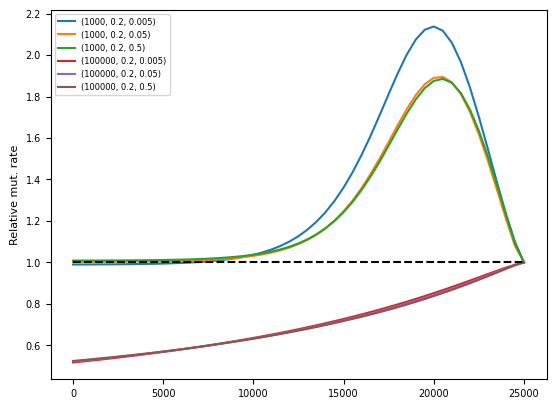

In [10]:
for k in outputs.keys():
    plt.plot(gens, outputs[k]["fixed_dfe"], label=str(k))
plt.plot(gens, np.ones(len(gens)), "k--")
plt.legend()
plt.ylabel("Relative mut. rate")

Text(0, 0.5, 'shape')

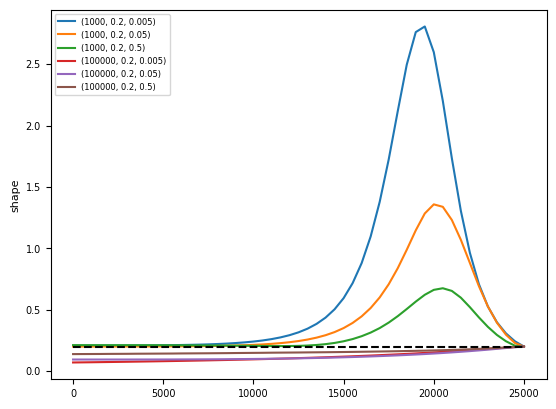

In [11]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0], label=str(k))
plt.plot(gens, np.ones(len(gens)) * shape, "k--")
#plt.yscale("log")
plt.legend()
plt.ylabel("shape")

Text(0, 0.5, 'scale')

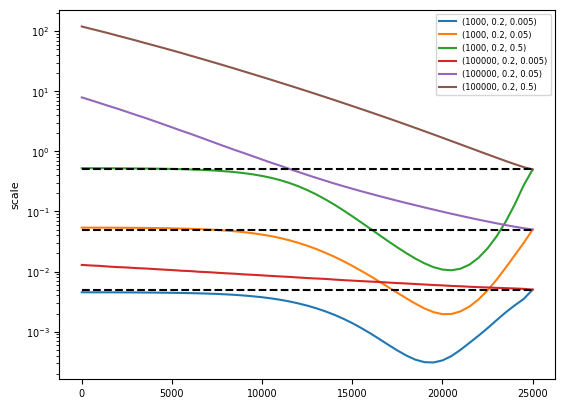

In [12]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 1], label=str(k))
for scale in scales:
    plt.plot(gens, np.ones(len(gens)) * scale, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("scale")

Text(0, 0.5, 'E[s]')

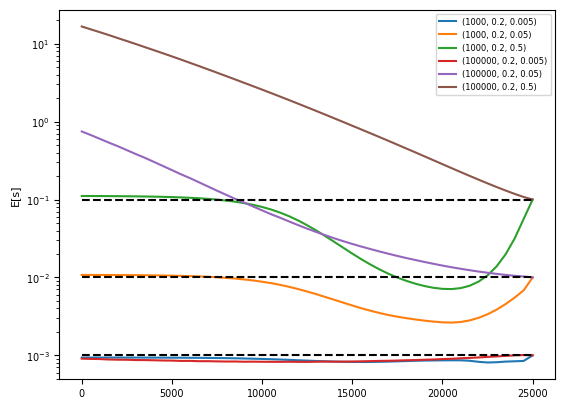

In [13]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1], label=str(k))
for scale in scales:
    plt.plot(gens, np.ones(len(gens)) * shape * scale, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("E[s]")

Text(0, 0.5, 'Var(s)')

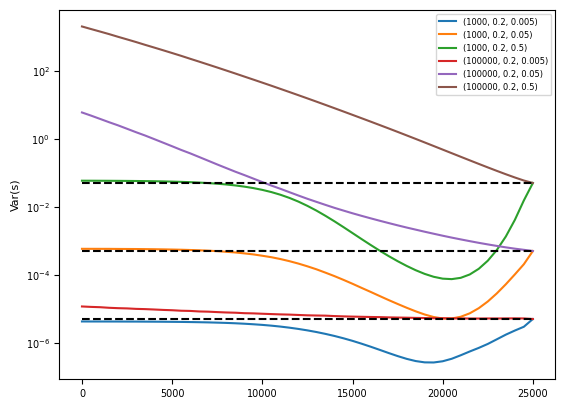

In [14]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1] ** 2, label=str(k))
for scale in scales:
    plt.plot(gens, np.ones(len(gens)) * shape * scale ** 2, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("Var(s)")

In [15]:
i = 0
fname = f"fit_dfe_2_epochs.{i}.pkl"
while os.path.exists(fname):
    i += 1
    fname = f"fit_dfe.{i}.pkl"
pickle.dump(outputs, open(fname, "wb+"))

In [16]:
from bokeh.palettes import Blues, Oranges
colors = {}
i = 2
j = 2
labels = {}
for k in outputs.keys():
    if k[0] == 1000:
        colors[k] = Blues[4][i]
        i -= 1
    if k[0] == 100000:
        colors[k] = Oranges[4][j]
        j -= 1
    labels[k] = f"{k[1], k[2]}"

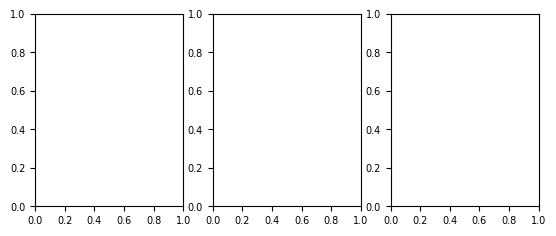

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.5))

In [18]:
axes[0].clear()
for k in outputs.keys():
    axes[0].plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0],
                 label=labels[k], color=colors[k])
axes[0].axhline(y=shape, linestyle='--', lw=0.75, color='gray', zorder=0)
axes[0].set_xlabel("Generations ago")
axes[0].set_ylabel("Shape")
axes[0].set_title(r"Fixed mutation rate")
axes[0].set_yscale("log")

In [19]:
axes[1].clear()
for k in outputs.keys():
    axes[1].plot(gens, np.array(outputs[k]["fixed_mu"])[:, 1],
                 label=labels[k], color=colors[k])
for scale in scales:
    axes[1].axhline(y=scale, linestyle='--', lw=0.75, color='gray', zorder=0)
axes[1].set_xlabel("Generations ago")
axes[1].set_ylabel("Scale")
#axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_title(r"Fixed mutation rate")

Text(0.5, 1.0, 'Fixed mutation rate')

In [20]:
axes[2].clear()
for k in outputs.keys():
    axes[2].plot(gens, np.array(outputs[k]["fixed_dfe"])[:, 0],
                 label=labels[k], color=colors[k])
axes[2].axhline(y=1, linestyle='--', lw=1, color='gray', zorder=0)
axes[2].set_xlabel("Generations ago")
axes[2].set_ylabel("Relative mutation rate")
axes[2].legend(handlelength=0.5, frameon=False, title=r"($\alpha$, $\beta$)", fontsize=6)
axes[2].set_title(r"Fixed DFE")
axes[2].set_ylim(top=2.5)

(0.4360302734374994, 2.5)

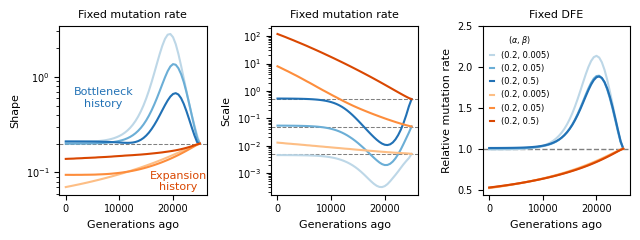

In [21]:
fig.tight_layout()
axes[0].text(7000, 0.6, "Bottleneck\nhistory", va="center", ha="center", color=Blues[4][0], fontsize=8)
axes[0].text(21000, 0.08, "Expansion\nhistory", va="center", ha="center", color=Oranges[4][0], fontsize=8)
fig

In [22]:
fig.text(0.02, 0.95, "A", fontsize=8, va="center", ha="center")
fig.text(0.35, 0.95, "B", fontsize=8, va="center", ha="center")
fig.text(0.65, 0.95, "C", fontsize=8, va="center", ha="center")
fig.tight_layout()


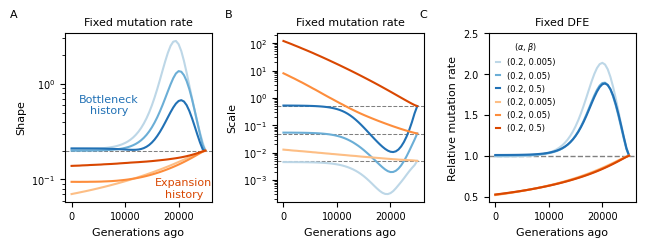

In [23]:
fig

In [24]:
fname = f"fit_dfe.shape_{shape}.scales_" + "_".join([str(sc) for sc in scales]) + "_2_epochs.svg"
fig.savefig(fname)

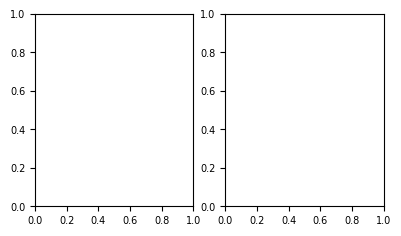

In [25]:
fig2, axes2 = plt.subplots(1, 2, figsize=(4.5, 2.5))

In [26]:
axes2[0].clear()
for k in outputs.keys():
    axes2[0].plot(gens,
                  np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1],
                  label=labels[k], color=colors[k])
for scale in scales:
    axes2[0].axhline(y=shape * scale, linestyle='--', lw=0.75, color='gray', zorder=0)
axes2[0].set_xlabel("Generations ago")
axes2[0].set_ylabel("E[s]")
axes2[0].set_title(r"Fixed mutation rate")
axes2[0].set_yscale("log")

In [27]:
axes2[1].clear()
for k in outputs.keys():
    axes2[1].plot(gens,
                  np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1] ** 2,
                  label=labels[k], color=colors[k])
for scale in scales:
    axes2[1].axhline(y=shape * scale ** 2, linestyle='--', lw=0.75, color='gray', zorder=0)
axes2[1].set_xlabel("Generations ago")
axes2[1].set_ylabel("Var(s)")
axes2[1].set_title(r"Fixed mutation rate")
axes2[1].set_yscale("log")

In [28]:
fig2.tight_layout()
fname = f"fit_dfe.mean_var.shape_{shape}.scales_" + "_".join([str(sc) for sc in scales]) + "_2_epochs.pdf"
fig2.savefig(fname)

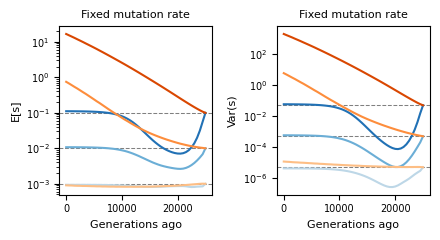

In [29]:
fig2